In [26]:
import torch
import os
import sys
import copy

In [27]:
import torch_scatter

In [28]:
import matplotlib.pyplot as plt
import geopandas as gpd

In [29]:
import numpy as np
import networkx as nx

In [30]:
import pandas as pd

In [31]:
import json

In [32]:
from mpl_toolkits.mplot3d import Axes3D

In [33]:
import wandb

In [34]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [35]:
results_dir = os.path.join('results','e5')

In [36]:
with open(os.path.join(results_dir, 'config.txt'), 'r') as file:
    config = json.load(file)

In [37]:
config['custom_optimizer'] = torch.optim.Adam

In [38]:
config

{'custom_optimizer': torch.optim.adam.Adam,
 'lr': 0.01,
 'epochs': 1000,
 'linear_layers': 2,
 'hidden_channels': 8,
 'dropout': 0.5,
 'graph_outchannels': 4,
 'graph_layers': 1,
 'graph_heads': 6,
 'test-percent': 15,
 'building_buffer': 100,
 'neighbor_radius': 100,
 'n_cv': 3,
 'cv_size': 600,
 'input_shape': 3}

In [39]:
import numpy as np
import pandas as pd

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

In [40]:
def graphplot(rebuilding_info, edges, bins=50, filename=None, title=None):
    """This is meant to input graph footprints, nodes, edges and output a density plot of distances"""
    buildinggeoms = rebuilding_info['footprints'].geometry.centroid[edges[0]].reset_index(drop=True)
    nodegeoms = rebuilding_info['node_data_original'].geometry[edges[1]].reset_index(drop=True)
    xs = buildinggeoms.geometry.x - nodegeoms.geometry.x
    ys = buildinggeoms.geometry.y - nodegeoms.geometry.y
    
    buildingdistance_df = pd.DataFrame({'building_id':edges[0], 'x': xs, 'y': ys})
    buildingdistance_df['rho'], buildingdistance_df['phi'] = cart2pol(buildingdistance_df.x, buildingdistance_df.y)
    z, azm, rad, _ = plt.hist2d(buildingdistance_df['phi'], buildingdistance_df['rho'], bins=bins)
    
    r, th = np.meshgrid(rad, azm)
    fig = plt.figure(dpi=500)
    ax = Axes3D(fig)
    ax.set_ylim([0, 200])

    # ax.set_ylim(0,200)
    plt.subplot(projection="polar")
    plt.pcolormesh(th, r, np.log(z))
    #plt.pcolormesh(th, z, r)

    plt.plot(azm, r, color='k', ls='none') 
    plt.grid()
    plt.ylim(0,200)
    # plt.thetagrids([theta * 15 for theta in range(360//15)])
    plt.rgrids(np.arange(0, max(buildingdistance_df['rho']), 100))
    if filename is not None:
        plt.title(title)
        plt.savefig(os.path.join(results_dir, filename))
    return fig, buildingdistance_df

In [41]:
from src.graph_construction import graph
nycgraph, nyc_rebuild_info = graph(
    "new-york",
    neighbor_radius=config['neighbor_radius'],
    building_buffer=config['building_buffer'],
    test_percent=config['test-percent']
)

# nycgraph = transform(nycgraph)

In [42]:
nyc_rebuild_info['footprints']

id  \
0       9831628575705046469   
1       4799432601768318575   
2      13432446276874400043   
3      12409346627080844976   
4      16920889134437381520   
...                     ...   
13410   3162522797862880947   
13411   2309459729724129729   
13412   3010589633849135112   
13413   5418421121047772298   
13414  15242956676492688919   

                                                geometry       energy  \
0      POLYGON ((585927.699 4510953.665, 585901.046 4...  1022.022331   
1      POLYGON ((585808.805 4510929.549, 585798.549 4...  1661.980018   
2      POLYGON ((585773.377 4510859.361, 585750.802 4...  2732.806140   
3      POLYGON ((585887.702 4510885.394, 585862.078 4...  1440.605929   
4      POLYGON ((585752.965 4510960.067, 585746.097 4...  2305.142743   
...                                                  ...          ...   
13410  POLYGON ((587289.030 4515245.943, 587207.798 4...  1207.394511   
13411  POLYGON ((595643.225 4511095.438, 595625.778 4...  3848.467852   
13412  POLYGON ((586796.159 4509068.953, 586792.590 4...  4136.360394   
13413  POLYGON ((592755.083 4508579.412, 592751.726 4...   537.698770   
13414  POLYGON ((587808.975 4516068.062, 587741.570 4...   784.407552   

               area  year          hdd          cdd  
0       4982.209051  2012  1624.918473  5363.637485  
1       7100.586219  2012  1939.211581  5301.015337  
2      15977.573184  2012  2127.859632  5236.836783  
3       7022.361783  2012  1592.129588  5359.351330  
4      11217.588421  2012  2331.513863  5215.119099  
...             ...   ...          ...          ...  
13410   2015.997919  2016  3541.572951  2782.841812  
13411  12485.809047  2016  2936.493480  5365.796272  
13412   8953.353338  2012  2388.908408  5245.983291  
13413   1323.869601  2017  2669.791720  5059.377001  
13414   1207.740689  2016  3393.641800  3264.480132  

[13415 rows x 7 columns]

In [43]:
nycedges = nycgraph['footprint','contains','pano']['edge_index'].cpu().detach().numpy()

buildinggeoms = nyc_rebuild_info['footprints'].geometry.centroid[nycedges[0]].reset_index(drop=True)
nodegeoms = nyc_rebuild_info['node_data_original'].geometry[nycedges[1]].reset_index(drop=True)
xs = buildinggeoms.geometry.x - nodegeoms.geometry.x
ys = buildinggeoms.geometry.y - nodegeoms.geometry.y

# buildingdistance_df = pd.DataFrame({'building_id':nyc_rebuild_info['footprints']['id'][nycedges[0]], 'x': xs, 'y': ys})

In [44]:
device = 'cuda:0'

In [45]:
torch.tensor(xs).to(device)

tensor([100.0920,  -9.5847, -53.4168,  ..., -89.9852, -95.0512, -99.7283],
       device='cuda:0', dtype=torch.float64)

In [46]:
def scatteridc(terms, idx, func):
    return func(
        torch.tensor(terms).to(device), 
        torch.tensor(idx).to(device), 
        dim=0
    ).detach().cpu().numpy()

In [47]:
from collections import Counter

node_counts = np.array(list(Counter(nycedges[0]).values()))

In [48]:
nycedges[0]

array([   0,    1,    2, ..., 9284, 9284, 9284])

In [49]:
xbar = scatteridc(xs, nycedges[0], torch_scatter.scatter_mean)
xstd = scatteridc(xs, nycedges[0], torch_scatter.scatter_std)

ybar = scatteridc(ys, nycedges[0], torch_scatter.scatter_mean)
ystd = scatteridc(ys, nycedges[0], torch_scatter.scatter_std)

In [50]:
len(ybar)

13415

In [51]:
len(node_counts)

13415

In [52]:
nyc_typical_locations = pd.DataFrame({'xbar':xbar, 'xstd': xstd, 'ybar': ybar, 'ystd': ystd, 'count': node_counts})

In [53]:
nycgraph

HeteroData(
  pano={ x=[89488, 3] },
  footprint={
    x=[13415, 3],
    y=[13415],
    train_mask=[13415],
    test_mask=[13415]
  },
  (footprint, contains, pano)={ edge_index=[2, 599220] },
  (pano, links, pano)={ edge_index=[2, 3636216] },
  (pano, rev_contains, footprint)={ edge_index=[2, 599220] }
)

In [54]:
nyc_typical_locations

xbar       xstd       ybar       ystd  count
0      -4.100662  53.012214 -22.389841  53.067936     43
1     -10.054313  61.698361 -22.453129  50.824561     30
2      28.572728  55.148708   5.869466  70.864438     38
3      -4.780175  65.241624 -22.111381  60.609199     32
4      10.677832  54.003786 -13.186441  49.164200     49
...          ...        ...        ...        ...    ...
13410  -0.728808  78.278203 -33.109932  42.834938     65
13411   8.109431  70.331593  -1.808082  68.261973     22
13412 -63.080328  13.730254  -6.084108  73.236397     77
13413  -8.914487  65.315924  10.903162  55.306337     16
13414  18.057756  77.806400  27.461932  43.359523     52

[13415 rows x 5 columns]

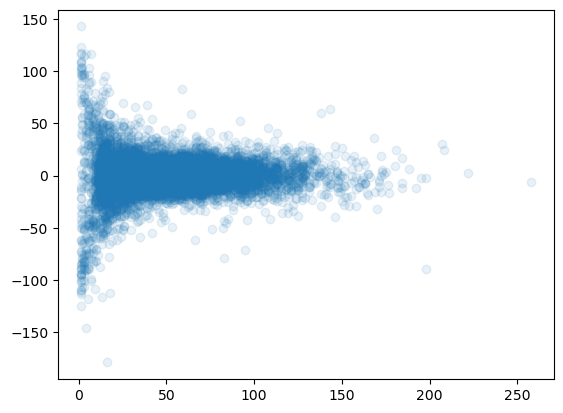

In [55]:
plt.scatter(nyc_typical_locations['count'], nyc_typical_locations['ybar'], alpha=0.1)

In [56]:
from src.graph_construction import graph
sfgraph, sf_rebuild_info = graph(
    "san-fransisco",
    neighbor_radius=config['neighbor_radius'],
    building_buffer=config['building_buffer'],
    test_percent=config['test-percent']
)

FileNotFoundError: [Errno 2] No such file or directory: '/home/thomas/Work/Research/uil/dbr/data/san-fransisco/config.yml'

In [ ]:
sfedges = sfgraph['footprint','contains','pano']['edge_index'].cpu().detach().numpy()

sfbuildinggeoms = sf_rebuild_info['footprints'].geometry.centroid[sfedges[0]].reset_index(drop=True)
sfnodegeoms = sf_rebuild_info['node_data_original'].geometry[sfedges[1]].reset_index(drop=True)
sfxs = sfbuildinggeoms.geometry.x - sfnodegeoms.geometry.x
sfys = sfbuildinggeoms.geometry.y - sfnodegeoms.geometry.y

xbar = scatteridc(sfxs, sfedges[0], torch_scatter.scatter_mean)
xstd = scatteridc(sfxs, sfedges[0], torch_scatter.scatter_std)

ybar = scatteridc(sfys, sfedges[0], torch_scatter.scatter_mean)
ystd = scatteridc(sfys, sfedges[0], torch_scatter.scatter_std)

sfedges = sfgraph['footprint','contains','pano']['edge_index'].cpu().detach().numpy()
node_counts = np.array(list(Counter(sfedges[0]).values()))

sf_typical_locations = pd.DataFrame({'xbar':xbar, 'xstd': xstd, 'ybar': ybar, 'ystd': ystd, 'count': node_counts})

# buildingdistance_df = pd.DataFrame({'building_id':nyc_rebuild_info['footprints']['id'][nycedges[0]], 'x': xs, 'y': ys})

In [ ]:
device = "cuda:0"

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from src.cv import build_masks, crossvalidation

In [ ]:
import torch_geometric.transforms as T
transform = T.Compose([T.ToUndirected(), T.AddSelfLoops()])

In [57]:
config['input_shape'] = nycgraph['footprint'].x.shape[1]

In [58]:
config

{'custom_optimizer': torch.optim.adam.Adam,
 'lr': 0.01,
 'epochs': 1000,
 'linear_layers': 2,
 'hidden_channels': 8,
 'dropout': 0.5,
 'graph_outchannels': 4,
 'graph_layers': 1,
 'graph_heads': 6,
 'test-percent': 15,
 'building_buffer': 100,
 'neighbor_radius': 100,
 'n_cv': 3,
 'cv_size': 600,
 'input_shape': 3}

In [59]:
nycgraph

HeteroData(
  pano={ x=[89488, 3] },
  footprint={
    x=[13415, 3],
    y=[13415],
    train_mask=[13415],
    test_mask=[13415]
  },
  (footprint, contains, pano)={ edge_index=[2, 599220] },
  (pano, links, pano)={ edge_index=[2, 3636216] },
  (pano, rev_contains, footprint)={ edge_index=[2, 599220] }
)

In [60]:
nyedges = nycgraph['footprint','contains','pano']['edge_index'].cpu().detach().numpy()

In [61]:
nycgraph['footprint'].x[np.array(nyc_rebuild_info['rebuild_idx'])]

tensor([[-0.4644, -2.0464,  1.0194],
        [-0.0039, -1.4943,  0.9085],
        [ 1.0502, -1.1629,  0.7949],
        ...,
        [ 0.2974, -0.7043,  0.8111],
        [-2.1871, -0.2108,  0.4808],
        [-2.3064,  1.0608, -2.6965]], device='cuda:0')

In [62]:
config

{'custom_optimizer': torch.optim.adam.Adam,
 'lr': 0.01,
 'epochs': 1000,
 'linear_layers': 2,
 'hidden_channels': 8,
 'dropout': 0.5,
 'graph_outchannels': 4,
 'graph_layers': 1,
 'graph_heads': 6,
 'test-percent': 15,
 'building_buffer': 100,
 'neighbor_radius': 100,
 'n_cv': 3,
 'cv_size': 600,
 'input_shape': 3}

In [65]:
nycgraph, nyc_rebuild_info = graph(
    "new-york",
    neighbor_radius=config['neighbor_radius'],
    building_buffer=300,
    test_percent=config['test-percent']
)

/tmp/ipykernel_13527/91360642.py:19: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(th, r, np.log(z))
/tmp/ipykernel_13527/91360642.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(th, r, np.log(z))


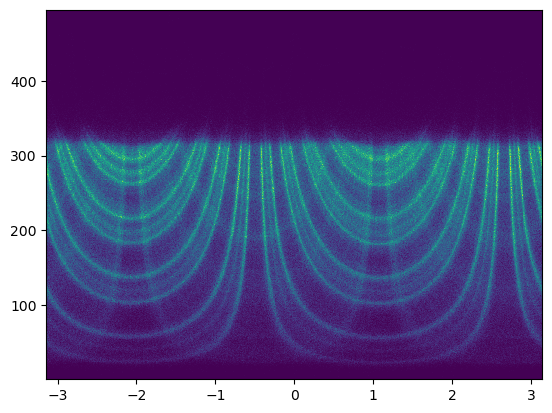

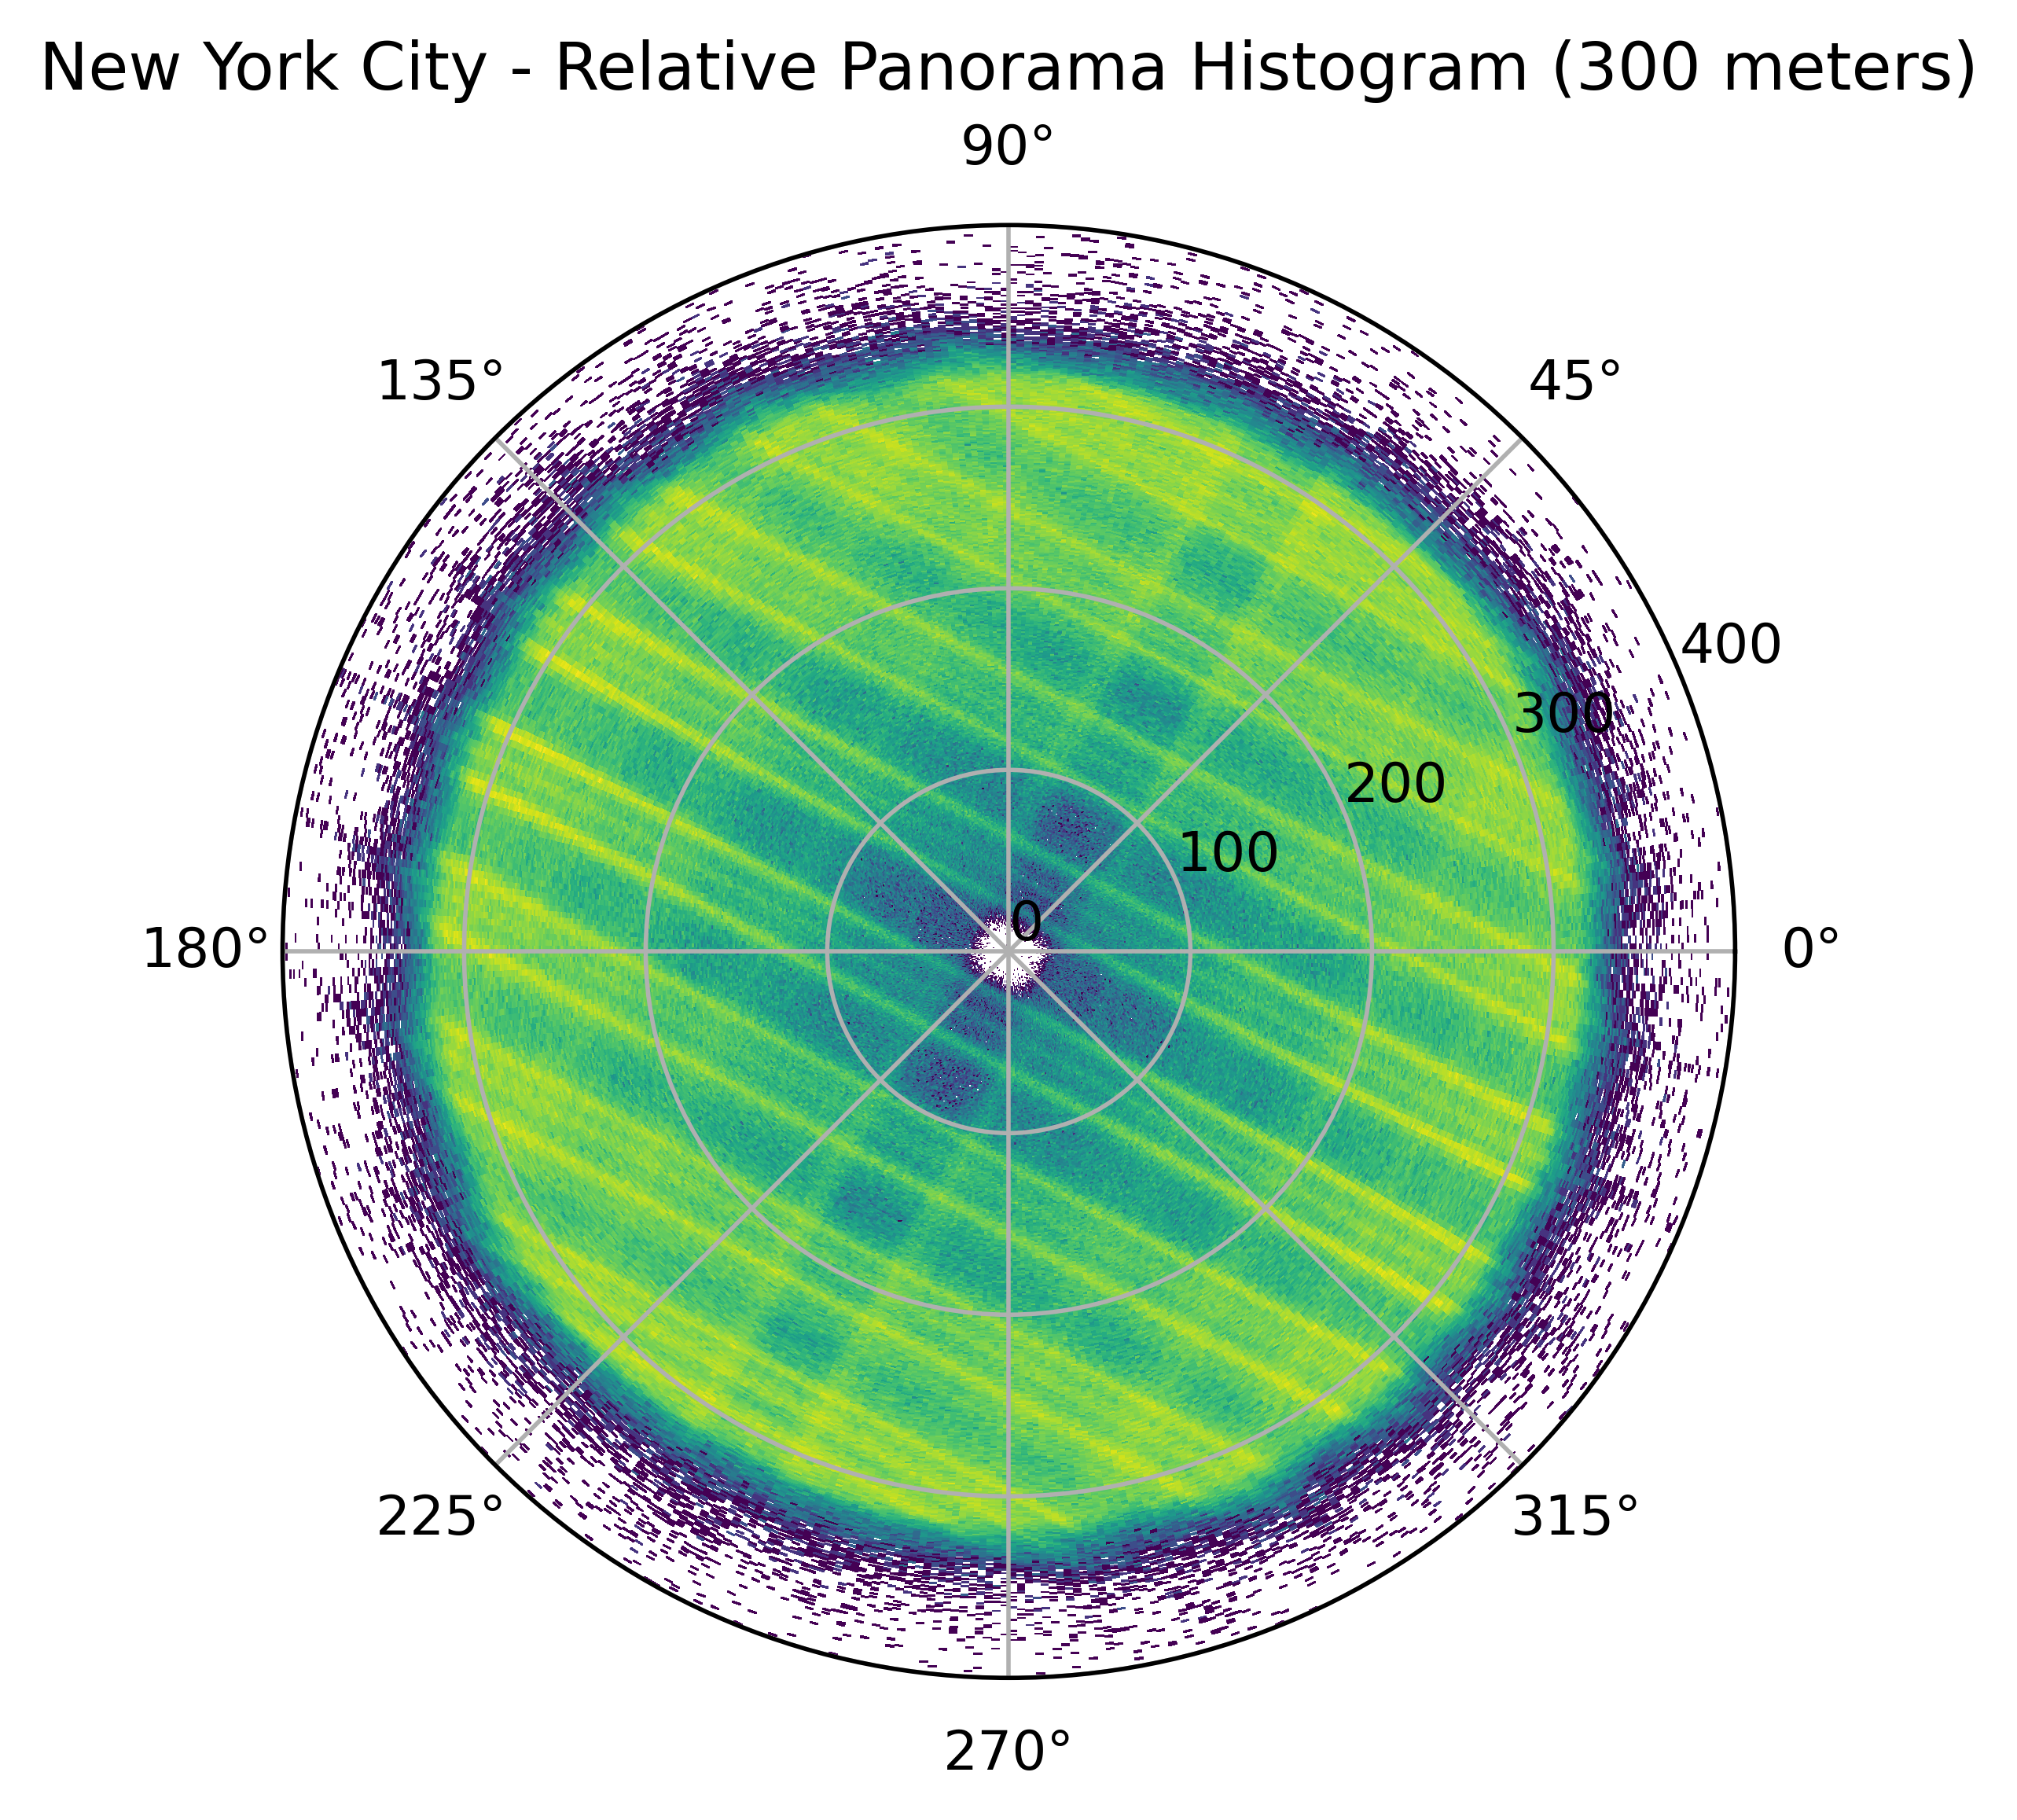

In [66]:
polarplot, building_info = graphplot(
    nyc_rebuild_info,
    nycgraph['footprint','contains','pano']['edge_index'].cpu().detach().numpy(), 
    bins = 500,
    filename = "new-york-distances-300.png",
    title = "New York City - Relative Panorama Histogram (300 meters)"
)

In [94]:
building_details = building_info.groupby('building_id').apply(lambda x: x.count()).reset_index(drop=True)

In [95]:
building_details

building_id   x   y  rho  phi
0               54  54  54   54   54
1               48  48  48   48   48
2               42  42  42   42   42
3               57  57  57   57   57
4               33  33  33   33   33
...            ...  ..  ..  ...  ...
10935           77  77  77   77   77
10936           25  25  25   25   25
10937           87  87  87   87   87
10938           18  18  18   18   18
10939           60  60  60   60   60

[10940 rows x 5 columns]

In [96]:
building_info['sin'] = np.sin(building_info['phi'])
building_info['cos'] = np.cos(building_info['phi'])

In [97]:
building_details = building_info.groupby('building_id').agg({'rho': ['mean','std'], 'sin': 'std', 'cos': 'std'})

In [98]:
building_details

rho                  sin       cos
                  mean        std       std       std
building_id                                          
0            74.637179  28.330927  0.752335  0.649741
1            85.970727  17.788082  0.679585  0.715838
2            84.044674  24.440619  0.733866  0.677747
3            84.634763  24.652262  0.713479  0.670573
4            81.445001  27.105873  0.662239  0.723819
...                ...        ...       ...       ...
10935        89.091084  35.791556  0.504493  0.785090
10936        94.370617  32.047116  0.754622  0.686800
10937        95.376435  23.357506  0.682661  0.229595
10938        82.420113  25.931114  0.736537  0.709161
10939        90.840979  26.898841  0.493546  0.732066

[10940 rows x 4 columns]

In [99]:
nycgraph

HeteroData(
  pano={ x=[86075, 3] },
  footprint={
    x=[10940, 3],
    y=[24740],
    train_mask=[10940],
    test_mask=[10940]
  },
  (footprint, contains, pano)={ edge_index=[2, 634103] },
  (pano, links, pano)={ edge_index=[2, 4442807] },
  (pano, rev_contains, footprint)={ edge_index=[2, 634103] }
)

In [67]:
config

{'custom_optimizer': torch.optim.adam.Adam,
 'lr': 0.01,
 'epochs': 1000,
 'linear_layers': 2,
 'hidden_channels': 8,
 'dropout': 0.5,
 'graph_outchannels': 4,
 'graph_layers': 1,
 'graph_heads': 6,
 'test-percent': 15,
 'building_buffer': 100,
 'neighbor_radius': 100,
 'n_cv': 3,
 'cv_size': 600,
 'input_shape': 3}

In [68]:
from src.graph_construction import graph
austingraph, austin_rebuild_info = graph(
    "austin",
    neighbor_radius=config['neighbor_radius'],
    building_buffer=300,
    test_percent=config['test-percent']
)

In [69]:
austingraph

HeteroData(
  pano={ x=[5910, 3] },
  footprint={
    x=[147, 3],
    y=[147],
    train_mask=[147],
    test_mask=[147]
  },
  (footprint, contains, pano)={ edge_index=[2, 12625] },
  (pano, links, pano)={ edge_index=[2, 84480] },
  (pano, rev_contains, footprint)={ edge_index=[2, 12625] }
)

/tmp/ipykernel_13527/91360642.py:19: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(th, r, np.log(z))
/tmp/ipykernel_13527/91360642.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(th, r, np.log(z))


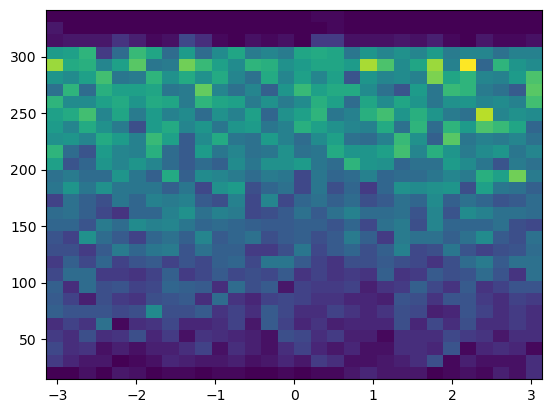

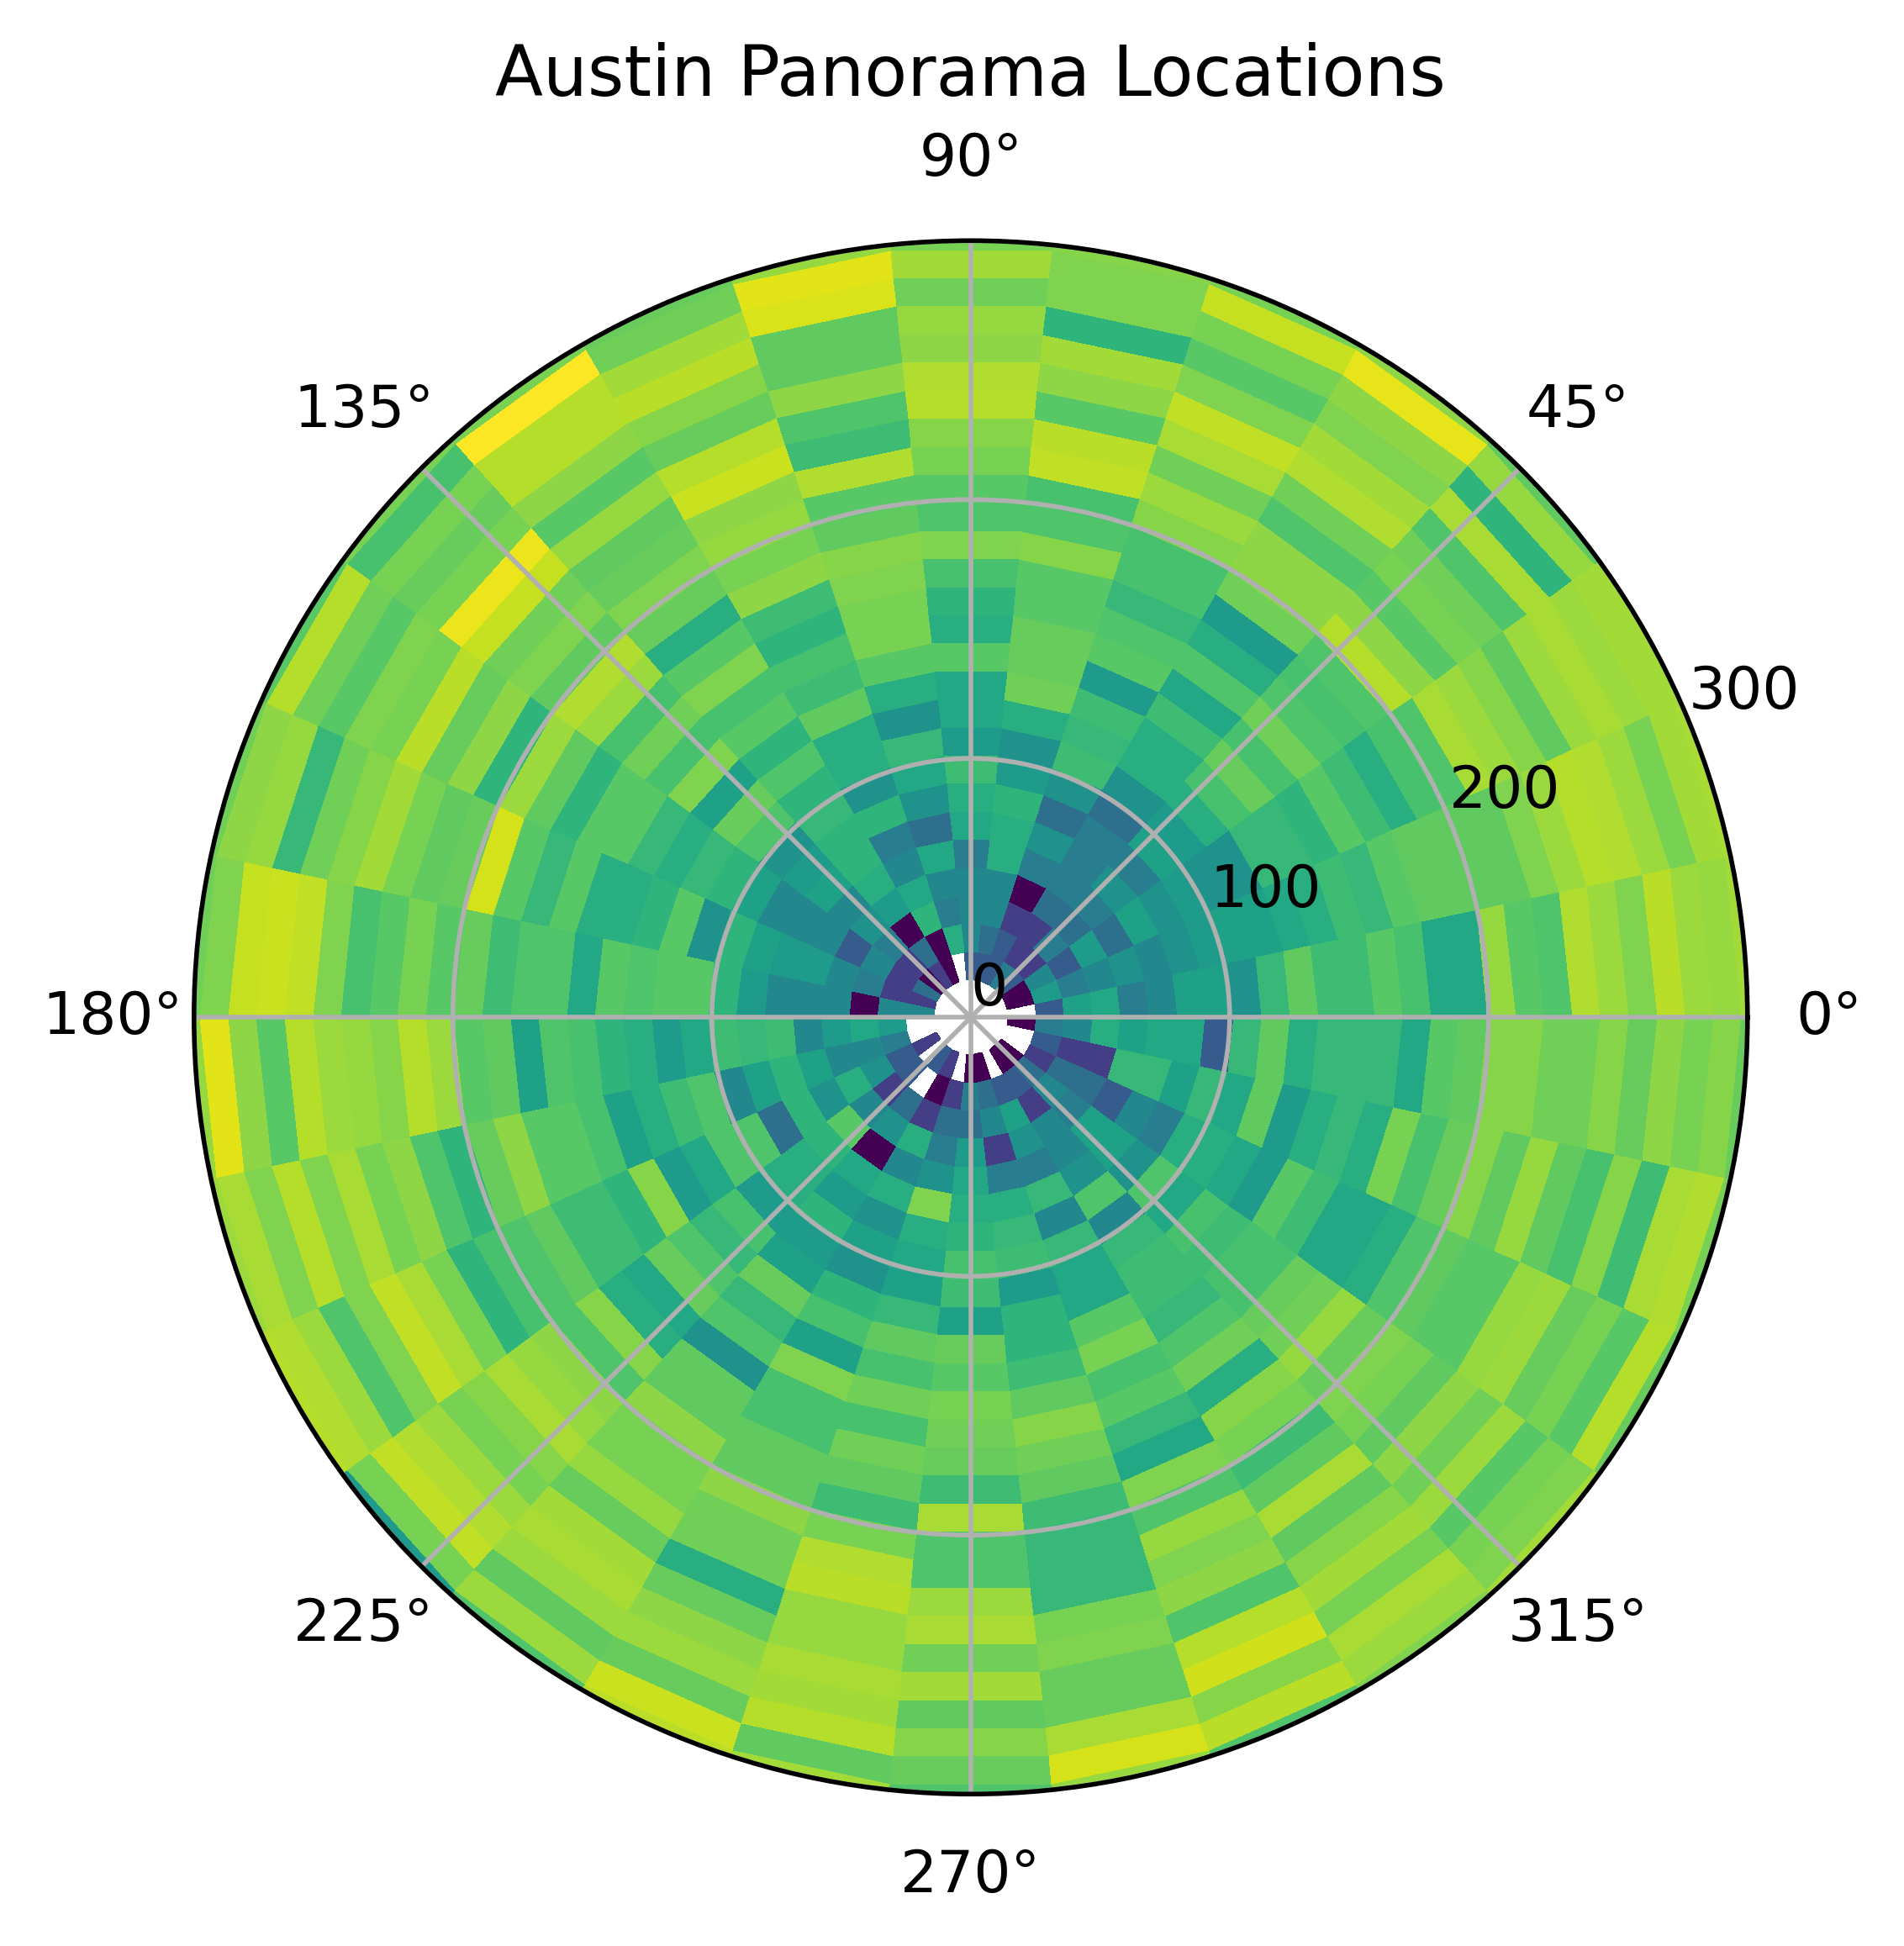

In [76]:
polarplot, building_info = graphplot(
    austin_rebuild_info,
    austingraph['footprint','contains','pano']['edge_index'].cpu().detach().numpy(), 
    bins = 30,
    filename = "austin-distances.png",
    title = "Austin Panorama Locations"
)

In [103]:
sfgraph

HeteroData(
  pano={ x=[11638, 3] },
  footprint={
    x=[1528, 3],
    y=[9613],
    train_mask=[1528],
    test_mask=[1528]
  },
  (footprint, contains, pano)={ edge_index=[2, 30445] },
  (pano, links, pano)={ edge_index=[2, 620866] },
  (pano, rev_contains, footprint)={ edge_index=[2, 30445] }
)

In [78]:
from src.graph_construction import graph
sfgraph, sf_rebuild_info = graph(
    "san-francisco",
    neighbor_radius=config['neighbor_radius'],
    building_buffer=300,
    test_percent=config['test-percent']
)

/tmp/ipykernel_13527/91360642.py:19: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(th, r, np.log(z))
/tmp/ipykernel_13527/91360642.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(th, r, np.log(z))


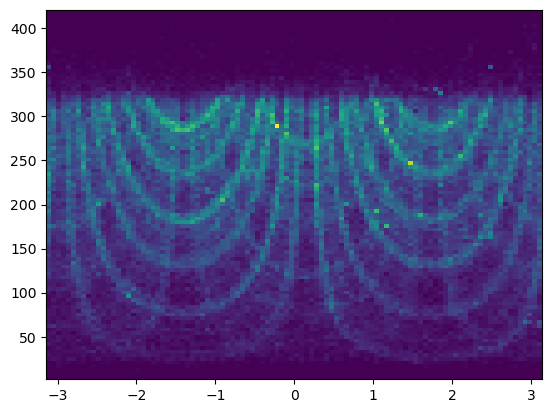

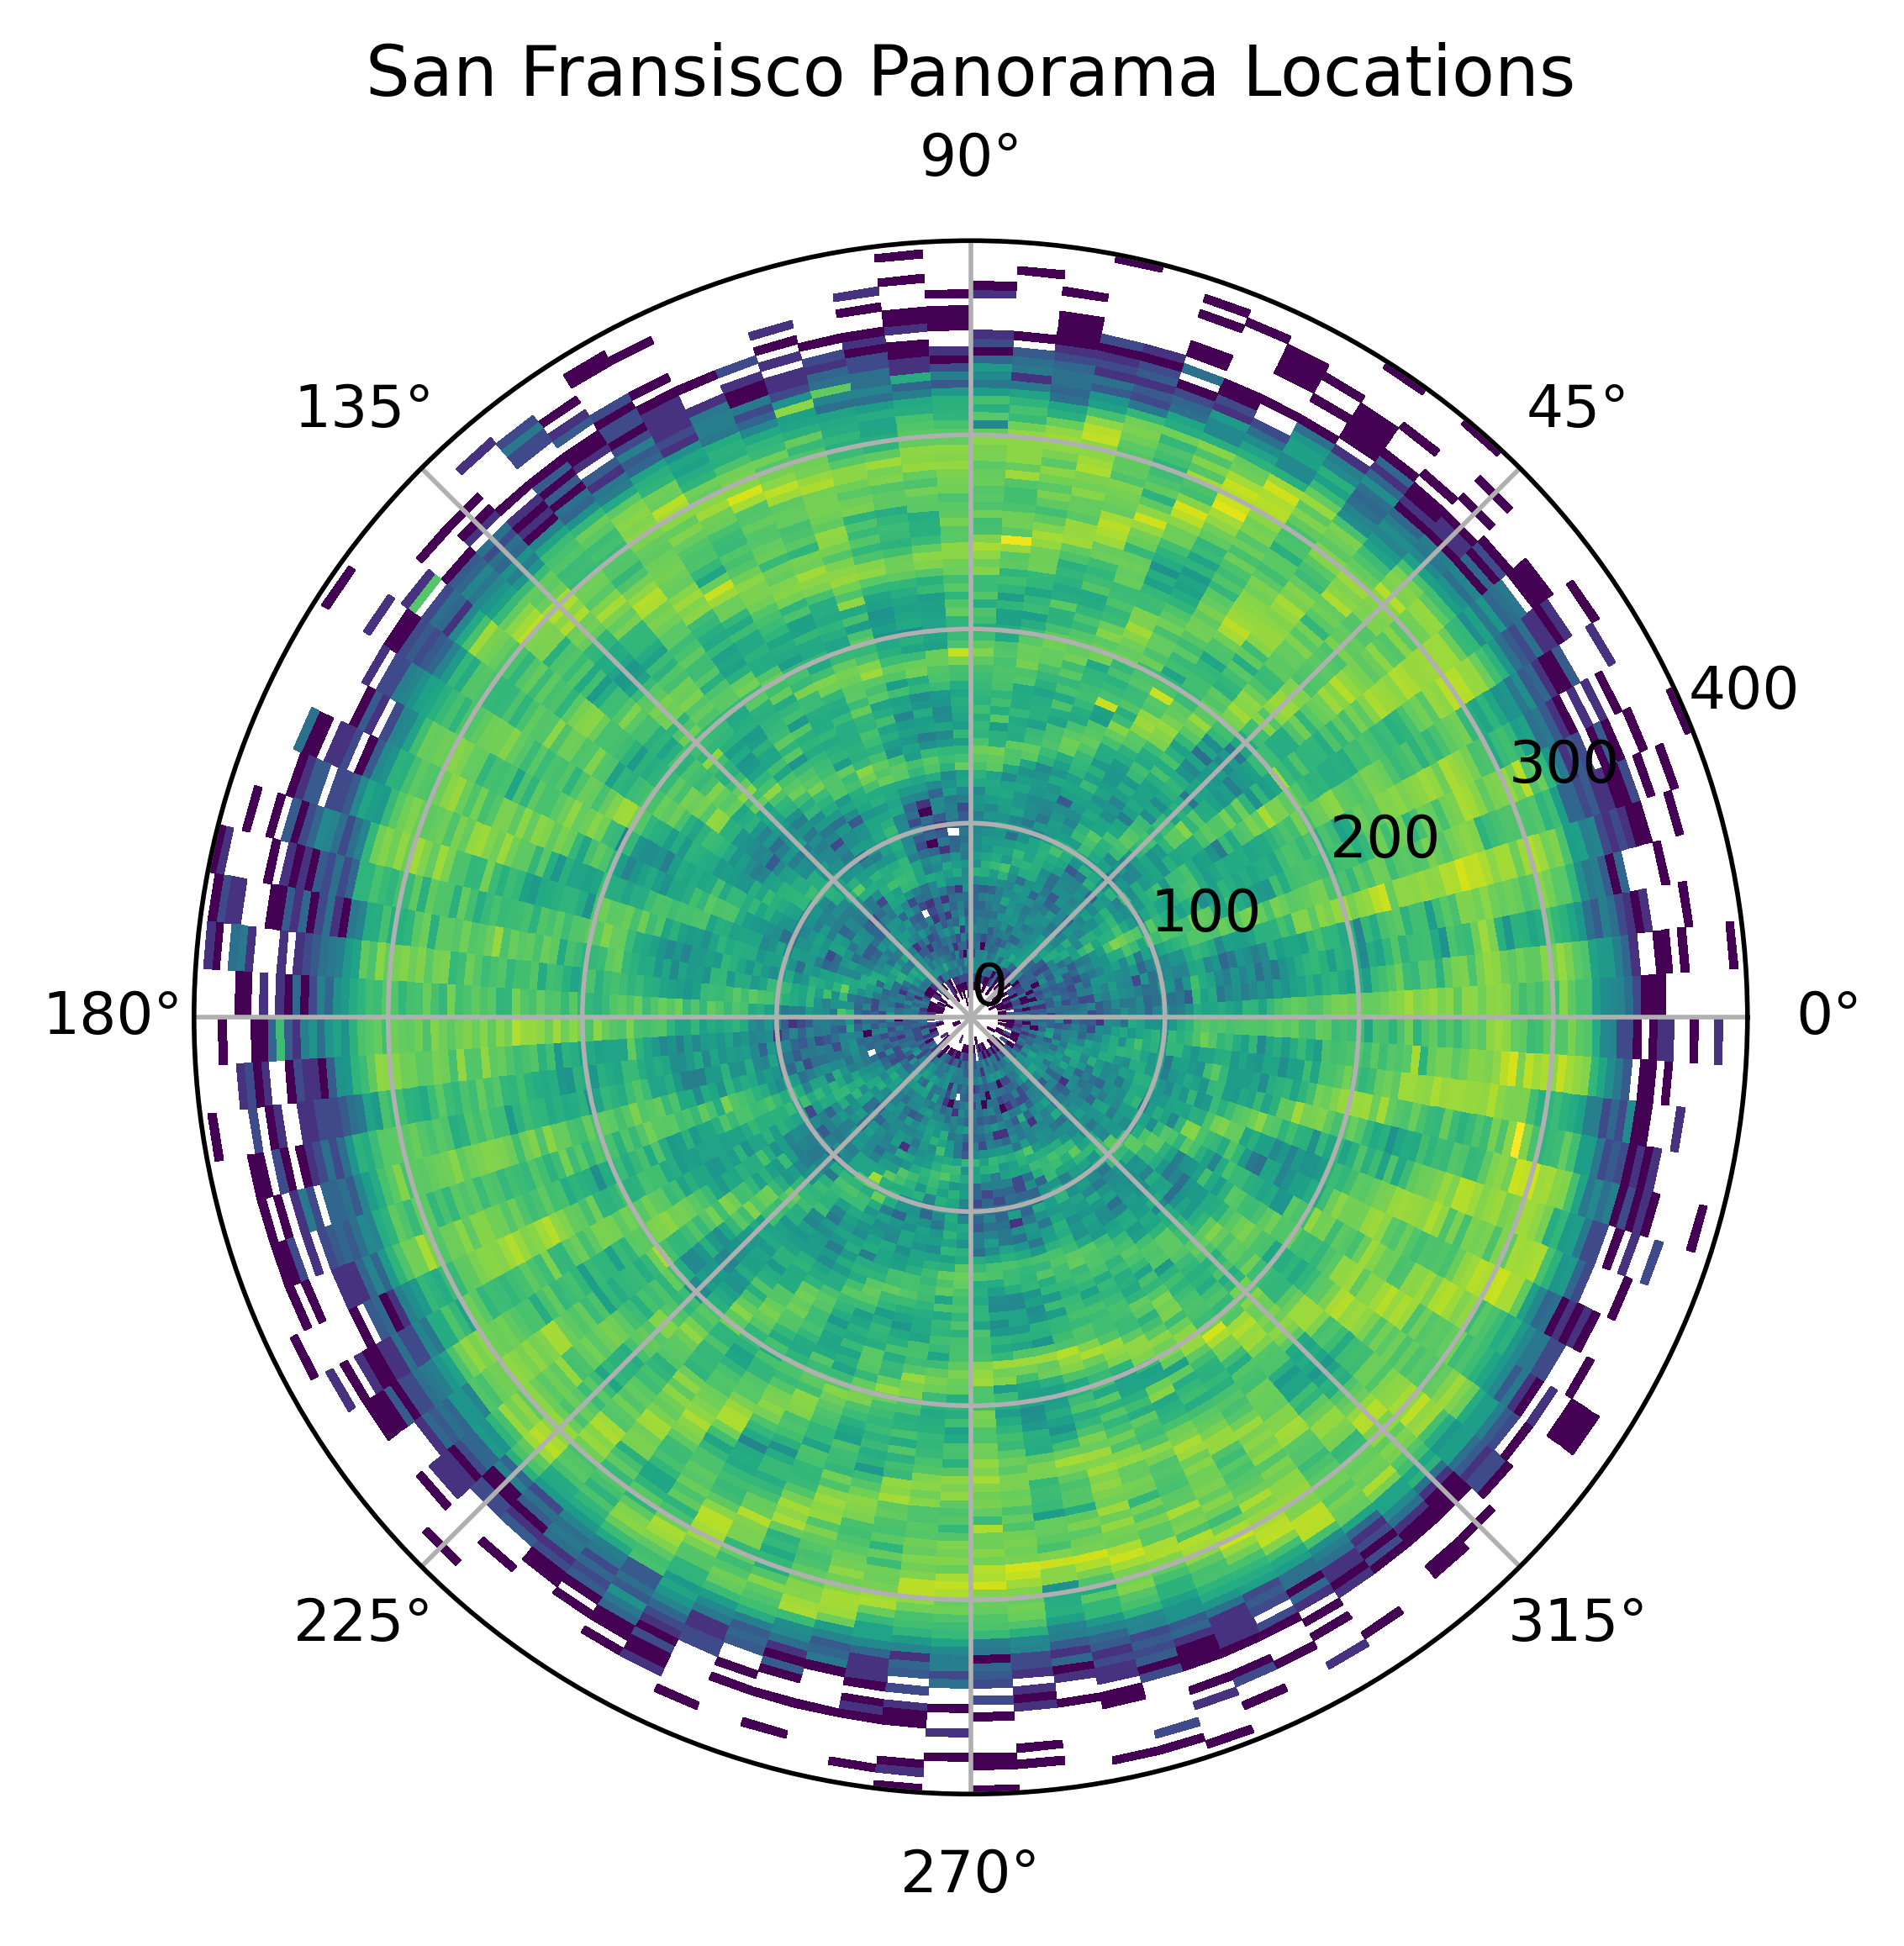

In [79]:
polarplot, building_info = graphplot(
    sf_rebuild_info,
    sfgraph['footprint','contains','pano']['edge_index'].cpu().detach().numpy(),
    bins=100,
    filename = "san-fransisco-distances.png",
    title = "San Fransisco Panorama Locations"
)

In [111]:
nyc_rebuild_info['training_mask'].sum()

tensor(9300, device='cuda:0')

In [112]:
(~nyc_rebuild_info['training_mask']).sum()

tensor(1640, device='cuda:0')

In [113]:
nyc_mask = nyc_rebuild_info['training_mask'].cpu().numpy()
nyc_cvs = build_masks(
    nyc_mask, 
    n_cv = 5,
    n_val = 10
)

In [114]:
loss_func = torch.nn.L1Loss()

In [115]:
checkpoint = torch.load(os.path.join(results_dir, 'state_dicts.tar'))

In [116]:
checkpoint.keys()

dict_keys(['default_graph_model', 'nygraph_model', 'default_null_model', 'ny_null_model', 'sf_extension', 'sf_extension_semi', 'sf_extension_null', 'sf_extension_null_semi'])

In [117]:
config['input_shape'] = nycgraph['footprint'].x.shape[1]

In [118]:
from src.model import NullModel

# input_shape = nycgraph['footprint'].x.shape[1]
nullmodel = NullModel(
    layers = config['linear_layers'],
    input_shape = config['input_shape'],
    hidden_channels = config['hidden_channels']
).to(device)

nullmodel.load_state_dict(checkpoint['sf_extension_null'])
nullmodel.eval()

NullModel(
  (linear_layer): Linear(in_features=3, out_features=1, bias=True)
  (mlp_start): Sequential(
    (0): Linear(in_features=3, out_features=8, bias=True)
    (1): ReLU()
  )
  (layer_compute): Sequential(
    (0): Sequential(
      (0): Linear(in_features=8, out_features=8, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=8, out_features=8, bias=True)
      (1): ReLU()
    )
  )
  (mlp_close): Linear(in_features=8, out_features=1, bias=True)
)

In [119]:
from src.model import CustomGAT

model = CustomGAT(
    hidden_channels = config['hidden_channels'], 
    out_channels=config['graph_outchannels'],
    layers=config['graph_layers'],
    heads=config['graph_heads'],
    linear_layers = config['linear_layers'],
    input_shape = config['input_shape'],
    dropout = config['dropout']
).to(device)

model.load_state_dict(checkpoint['nygraph_model'])
model.eval()

/home/thomas/miniconda3/envs/dbr/lib/python3.9/site-packages/torch_geometric/nn/conv/hetero_conv.py:58: UserWarning: There exist node types ({'pano'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behaviour.
  warnings.warn(


CustomGAT(
  (convs): ModuleList(
    (0): GATv2Conv((-1, -1), 8, heads=6)
  )
  (lins): ModuleList(
    (0): Linear(-1, 48, bias=True)
  )
  (nullmodel): NullModel(
    (linear_layer): Linear(in_features=3, out_features=1, bias=True)
    (mlp_start): Sequential(
      (0): Linear(in_features=3, out_features=8, bias=True)
      (1): ReLU()
    )
    (layer_compute): Sequential(
      (0): Sequential(
        (0): Linear(in_features=8, out_features=8, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=8, out_features=8, bias=True)
        (1): ReLU()
      )
    )
    (mlp_close): Linear(in_features=8, out_features=1, bias=True)
  )
  (conv_translate): HeteroConv(num_relations=1)
  (mlp): Sequential(
    (0): Linear(in_features=24, out_features=8, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=8, out_features=8, bias=True)
    (4): Dropout(p=0.3, inplace=False)
    (5): ReLU()
    (6): Linear(in_fe

In [120]:
model.eval()
nullmodel.eval()
with torch.no_grad():
    outputs = model(sfgraph.x_dict, sfgraph.edge_index_dict)
    nulloutputs = nullmodel(sfgraph['footprint'].x)

In [121]:
outputs

tensor([[8.0114],
        [7.1972],
        [7.4680],
        ...,
        [7.6976],
        [8.0265],
        [8.5773]], device='cuda:0')

In [122]:
nulloutputs

tensor([[7.4605],
        [6.1897],
        [6.7086],
        ...,
        [7.5460],
        [7.6834],
        [8.3640]], device='cuda:0')

In [123]:
sf_modelpredictions = outputs[sf_rebuild_info['rebuild_idx']].squeeze()

sf_modelerr = outputs[sf_rebuild_info['rebuild_idx']].squeeze() - sfgraph['footprint'].y

sf_nullmodelpredictions = nulloutputs[sf_rebuild_info['rebuild_idx']].squeeze()
sf_nullmodelerr = nulloutputs[sf_rebuild_info['rebuild_idx']].squeeze() - sfgraph['footprint'].y

In [124]:
sf_modelmean = torch_scatter.scatter_mean(sf_modelpredictions, torch.tensor(sf_rebuild_info['rebuild_idx']).to(device))
sf_nullmodelmean = torch_scatter.scatter_mean(sf_nullmodelpredictions, torch.tensor(sf_rebuild_info['rebuild_idx']).to(device))

sf_meanerrs = torch_scatter.scatter_mean(sf_modelerr, torch.tensor(sf_rebuild_info['rebuild_idx']).to(device))
sf_nullmeanerrs = torch_scatter.scatter_mean(sf_nullmodelerr, torch.tensor(sf_rebuild_info['rebuild_idx']).to(device))

In [125]:
sffootprints = copy.deepcopy(sf_rebuild_info['footprints'])
sffootprints['graph_predictions'] = np.exp(sf_modelmean.detach().cpu().numpy())
sffootprints['null_predictions'] = np.exp(sf_nullmodelmean.detach().cpu().numpy())

sffootprints['grapherr'] = sf_meanerrs.detach().cpu().numpy()
sffootprints['nullerr'] = sf_nullmeanerrs.detach().cpu().numpy()
sffootprints['graphdiff'] = sffootprints['nullerr'] - sffootprints['grapherr']

# sffootprints['geometry'] = sffootprints.geometry.centroid
sffootprints.explore('null_predictions')

In [127]:
sfgraph['footprint']['test_mask'].shape

torch.Size([1528])

In [128]:
sfgraph['footprint']['train_mask']

tensor([ True,  True, False,  ...,  True,  True,  True], device='cuda:0')

In [129]:
(np.abs(sffootprints['graph_predictions'] - sffootprints['energy']) < 500).sum() / len(sffootprints)

0.29450261780104714

In [130]:
(np.abs(sffootprints['null_predictions'] - sffootprints['energy']) < 500).sum() / len(sffootprints)

0.6014397905759162

In [131]:
sftestmask = sfgraph['footprint']['test_mask'].detach().cpu().numpy()

In [132]:
sftestlosses = sffootprints.join(sf_typical_locations).iloc[sftestmask]

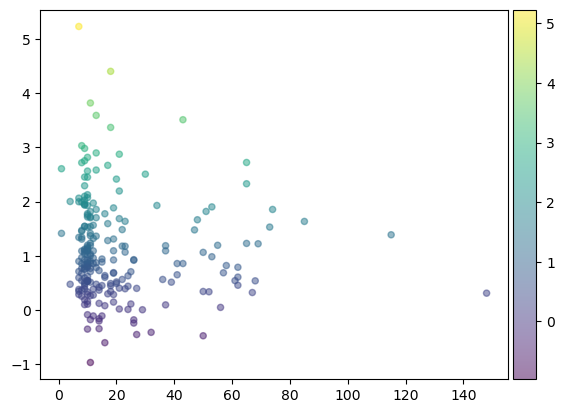

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.scatter(
    sftestlosses['count'],
    sftestlosses['grapherr'],
    c = sftestlosses['grapherr'],
    s=20,
    alpha=0.5,
    label='Error'
    # cmap = plt.cm.get_cmap('RdYlBu')
)

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

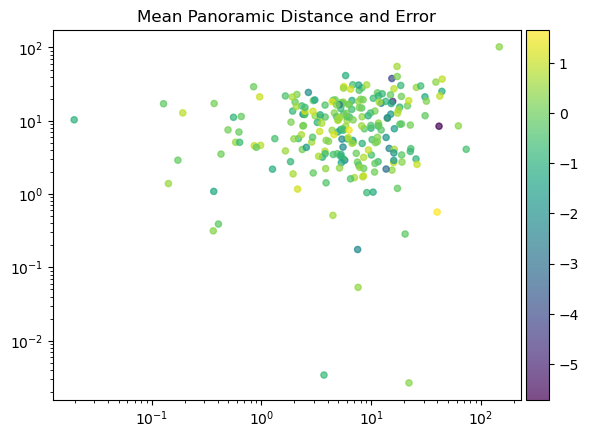

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots()
plt.title("Mean Panoramic Distance and Error")
plt.yscale('log')
plt.xscale('log')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.scatter(
    np.abs(sftestlosses['xbar']),
    np.abs(sftestlosses['ybar']),
    c = np.log(np.abs(sftestlosses['grapherr'])),
    s=20,
    alpha=0.7,
    label='Error'
    # cmap = plt.cm.get_cmap('RdYlBu')
)

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

In [135]:
np.power

<ufunc 'power'>

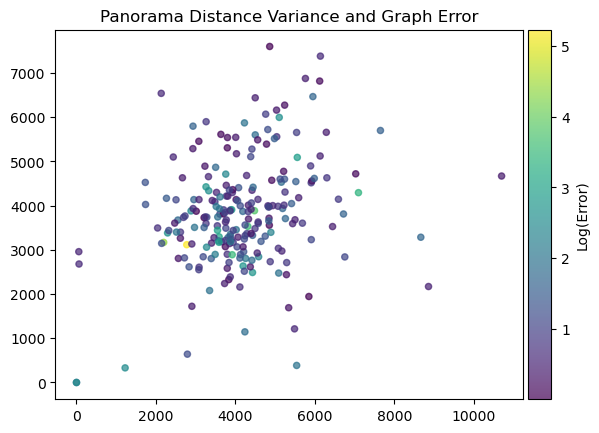

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots()
plt.title("Panorama Distance Variance and Graph Error")

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.scatter(
    np.power(sftestlosses['xstd'], 2),
    np.power(sftestlosses['ystd'], 2),
    c = np.abs(sftestlosses['grapherr']),
    s=20,
    alpha=0.7,
    label='Error'
    # cmap = plt.cm.get_cmap('RdYlBu')
)

fig.colorbar(im, cax=cax, orientation='vertical', label="Log(Error)")
plt.show()

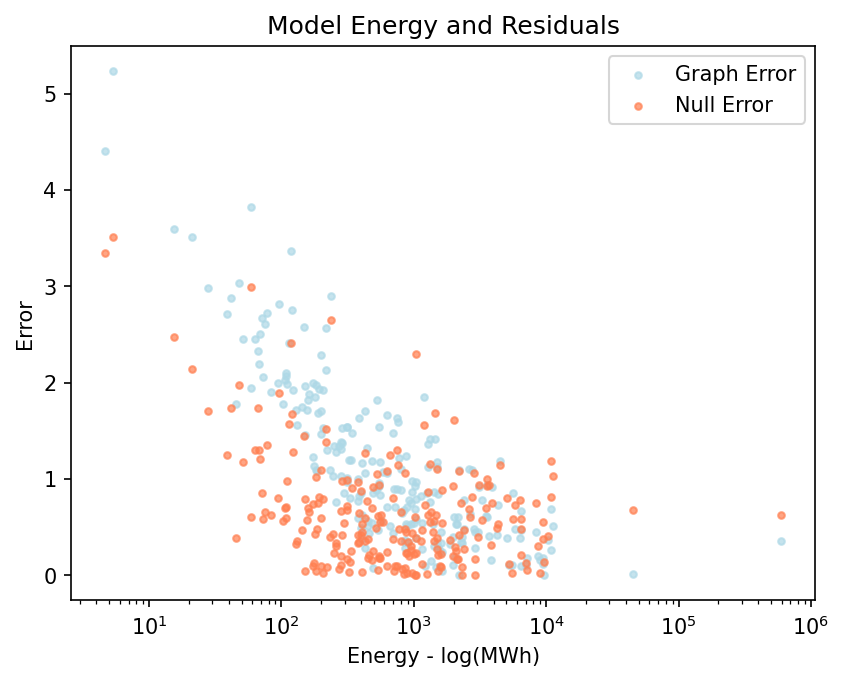

In [137]:
fig, ax = plt.subplots(dpi=150)
plt.title("Model Energy and Residuals")

# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.scatter(
    sftestlosses['energy'],
    np.abs(sftestlosses['grapherr']),
    # c = np.abs(sftestlosses['grapherr']),
    color="lightblue",
    s=10,
    alpha=0.7,
    label='Graph Error'
    # cmap = plt.cm.get_cmap('RdYlBu')
)

ax.scatter(
    sftestlosses['energy'],
    np.abs(sftestlosses['nullerr']),
    # c = np.abs(sftestlosses['grapherr']),
    color="coral",
    s=10,
    alpha=0.7,
    label='Null Error'
    # cmap = plt.cm.get_cmap('RdYlBu')
)

plt.xlabel("Energy - log(MWh)")
plt.ylabel("Error")
plt.xscale("log")
plt.legend()

# fig.colorbar(im, orientation='vertical', label="Log(Error)")
plt.show()

In [138]:
sftestlosses

id                                           geometry  \
2     12121787074080254590  MULTIPOLYGON (((551880.977 4180321.662, 551873...   
4      2677126369422367757  MULTIPOLYGON (((551882.023 4180306.472, 551882...   
5     15749506019692456695  MULTIPOLYGON (((551888.889 4180218.213, 551856...   
9     17825255587079831530  MULTIPOLYGON (((551683.643 4180531.918, 551691...   
14      352308450881228192  MULTIPOLYGON (((552148.646 4180527.543, 552126...   
...                    ...                                                ...   
1483  11723172613653575166  MULTIPOLYGON (((552053.514 4183793.138, 552066...   
1485   5868629992373364250  MULTIPOLYGON (((552015.948 4183872.666, 552026...   
1492  10959325443348309026  MULTIPOLYGON (((551803.834 4183876.060, 551805...   
1514  15027435420749504825  MULTIPOLYGON (((551295.988 4183961.991, 551296...   
1522  10565409669717106001  MULTIPOLYGON (((550134.124 4181024.651, 550135...   

      year       energy         area  amplitude       bias  graph_predictions  \
2     2012   522.969673  5943.097813  12.317663  31.003251        1751.092529   
4     2014   128.164557  1672.254000  12.409612  30.982178         712.241211   
5     2013   121.015002  3251.605000  12.460937  31.097770        1146.320435   
9     2016    50.857243  1550.458167  12.184727  31.213229         574.627319   
14    2013   183.638303  3934.070438  11.901103  30.767629        1280.232056   
...    ...          ...          ...        ...        ...                ...   
1483  2012  1626.875293  4273.538000  11.339229  29.119210        1258.926636   
1485  2013   405.261076  1586.318725  11.223950  29.059110         586.027832   
1492  2013   448.391702  2214.435908  11.796344  29.297329         768.008057   
1514  2021   847.603493  4833.464381  11.501851  28.648553        1669.406860   
1522  2019   231.790436  1262.737576  11.600946  30.077396         628.264526   

      null_predictions  grapherr   nullerr  graphdiff       xbar       xstd  \
2           819.447693  1.814896  1.055531  -0.759364  -6.042656  71.815791   
4           178.165085  1.715102  0.329396  -1.385706   5.570295  72.518442   
5           391.055756  2.752806  1.677343  -1.075463 -16.039436  57.099580   
9           161.494904  2.449335  1.180087  -1.269248 -16.116086  53.696120   
14          494.009735  1.971980  1.019738  -0.952241   7.040428  65.024063   
...                ...       ...       ...        ...        ...        ...   
1483        661.111328 -0.242834 -0.886926  -0.644093   3.066904  72.697407   
1485        198.791748  0.629305 -0.451805  -1.081110   4.514946  54.184017   
1492        299.445648  0.562146 -0.379722  -0.941868   9.845239  57.637901   
1514        833.831055  0.677811 -0.016382  -0.694193   3.800770  71.284373   
1522        141.837402  1.090354 -0.397925  -1.488280   6.254166  52.132161   

           ybar       ystd  count  
2    -10.134973  67.298458     11  
4    -17.992727  60.881547     10  
5     -2.685078  66.517280      9  
9    -27.324499  62.283560     10  
14     1.674917  76.620387     12  
...         ...        ...    ...  
1483 -19.253581  49.380308     26  
1485   3.469658  62.715224     24  
1492  12.792480  68.226377     36  
1514 -16.360147  55.080063     19  
1522 -16.574143  53.081283     37  

[229 rows x 17 columns]

In [139]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

X = sftestlosses[["xbar","ybar","xstd","ystd","count"]]
y = np.array(sftestlosses.grapherr)

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     3.913
Date:                Sun, 19 Mar 2023   Prob (F-statistic):            0.00202
Time:                        16:56:29   Log-Likelihood:                -294.62
No. Observations:                 229   AIC:                             601.2
Df Residuals:                     223   BIC:                             621.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4642      0.399      6.173      0.0

In [140]:
#### now I'm going to explore more linear models


In [ ]:
reg.coef_

In [ ]:
footprint_aggregations = sfgraph['footprint','contains','pano']['edge_index'][0]

In [ ]:
pano_manipulations = sfgraph['pano'].x[sfgraph['footprint','contains','pano']['edge_index'][1].detach().cpu().numpy()]

In [ ]:
nodecols = list(sf_rebuild_info['node_data'].columns)
nodecols.append('err')
nodecols

In [ ]:
pano_typicalterms = torch_scatter.scatter_mean(pano_manipulations, footprint_aggregations, dim=0)

In [ ]:
building_envterms = pd.DataFrame(pano_typicalterms.cpu().detach().numpy(), columns=list(sf_rebuild_info['node_data'].columns))
building_envterms

In [ ]:
sffootprints.join(building_envterms).explore('sky_area')

In [ ]:
pd.DataFrame(
    torch.hstack((pano_typicalterms, torch.tensor(sffootprints['graphdiff']).to(device).unsqueeze(1))).cpu().numpy(),
    columns= nodecols
).corr()

In [ ]:
sfgraph['pano']

In [ ]:
nycgraph['footprint'].x

In [ ]:
config = {
    "custom_optimizer": torch.optim.Adam,
    "lr" : 5e-2,
    'epochs': 300,
    'linear_layers': 2,
    'hidden_channels': 8,
    'input_shape': nycgraph['footprint'].x.shape[1],
    'dropout': 0.3
}

In [ ]:
from src.model import NullModel

# input_shape = nycgraph['footprint'].x.shape[1]
nullmodel = NullModel(
    layers = config['linear_layers'],
    input_shape = config['input_shape'],
    hidden_channels = config['hidden_channels']
).to(device)

null_training_tensor, null_validation_tensor = crossvalidation(
    nullmodel,
    lambda: nullmodel(nycgraph['footprint'].x),
    nyc_cvs,
    nyc_rebuild_info,
    epochs = config['epochs'],
    custom_optimizer = config['custom_optimizer'],
    lr = config['lr'],
    config = config,
    log_model = False
)

In [ ]:
null_mean_tl = null_training_tensor.mean(axis=0)
null_mean_vl = null_validation_tensor.mean(axis=0)

plt.plot(null_mean_tl, label="Null Training")
plt.plot(null_mean_vl, label="Null Validation")

plt.legend()

# plt.yscale("log")
plt.ylim((0,5))

plt.show()

In [ ]:
config

In [ ]:
from src.model import CustomGAT

model = CustomGAT(
    hidden_channels = config['hidden_channels'], 
    out_channels=8,
    layers=2,
    heads=4,
    linear_layers = config['linear_layers'],
    input_shape = config['input_shape'],
    dropout = config['dropout']
).to(device)

default_modelstate = model.state_dict()

In [ ]:
graph_training_tensor, graph_validation_tensor = crossvalidation(
    model,
    lambda: model(nycgraph.x_dict, nycgraph.edge_index_dict),
    nyc_cvs,
    nyc_rebuild_info,
    epochs= config['epochs'],
    custom_optimizer = config['custom_optimizer'],
    lr = config['lr'],
    config=config,
    log_model=False
)

In [ ]:
mean_tl = graph_training_tensor.mean(axis=0)
std_tl = graph_training_tensor.std(axis=0)

mean_vl = graph_validation_tensor.mean(axis=0)
std_vl = graph_validation_tensor.std(axis=0)

plt.plot(mean_tl, label="Graph Training")
plt.plot(mean_vl, label="Graph Validation")
plt.legend()

# plt.yscale("log")
plt.ylim((0,2))

plt.show()

In [ ]:
nycfootprints = nyc_rebuild_info['footprints']
nycfootprints['logenergy'] = np.log(nycfootprints.energy)

# nycfootprints.explore('logenergy')

In [ ]:
domain = np.arange(0, len(mean_tl))

plt.plot(domain, mean_tl, label="Training")
plt.plot(domain, mean_vl, label="Validation", color="lightblue")
# plt.fill_between(domain, mean_vl + std_vl, mean_vl - std_vl, alpha=0.1)

plt.plot(domain, null_mean_tl, label="Null Training", color="indianred", linestyle='dashed')
plt.plot(domain, null_mean_vl, label="Null Validation", color="salmon", linestyle='dashed')

plt.hlines(linear_regerr, min(domain), max(domain), color='pink', label="linear regression")

plt.title(f"Loss Function with Training - lr: {config['lr']}")

plt.xlabel("Epoch")
plt.ylabel("Training Loss - MSE")
plt.legend()

plt.yscale("log")
plt.ylim((0,2.5))

plt.show()

In [ ]:
graph_improvement = (min(mean_vl) - min(null_mean_vl)) / min(null_mean_vl)
print("Improvement from Context: {:0.2f}%".format(100*graph_improvement))

In [ ]:
def relative_benefit(errors, threshold):
    count_pass = (errors <= threshold).sum()
    return float(100 * (count_pass / len(errors)))

In [ ]:
# now examining how this may generalize
with torch.no_grad():
    print("New York City")
    rebuilding_idx = nyc_rebuild_info['rebuild_idx'].cpu().numpy()

    linear_predictions = reg.predict(nycgraph['footprint'].x.cpu().numpy())[rebuilding_idx]
    null_predictions = nullmodel(nycgraph['footprint'].x).squeeze()[rebuilding_idx]
    estimates = model(nycgraph.x_dict, nycgraph.edge_index_dict).squeeze().detach()[rebuilding_idx]
    recorded = nyc_rebuild_info['recorded']

    linear_loss = loss_func(torch.tensor(linear_predictions).to(device), recorded)
    null_loss = loss_func(null_predictions, recorded)
    graph_loss = loss_func(estimates, recorded)
    
    print("Linear Loss:\t{:0.2f}".format(linear_loss))
    print("Null Loss:\t{:0.2f}".format(null_loss))
    print("Graph Loss:\t{:0.2f}".format(graph_loss))
    print("Improvement:\t{:0.2f}".format(100 * (graph_loss - null_loss)/null_loss))

In [ ]:
linmae = torch.abs(torch.exp(recorded) - torch.tensor(np.exp(linear_predictions)).to(device))
nullmae = torch.abs(torch.exp(recorded) - torch.exp(null_predictions))
graphmae = torch.abs(torch.exp(recorded) - torch.exp(estimates))

In [ ]:
threshold = 500

print(f"Relative Benefit:\t{relative_benefit(linmae, threshold)}")
print(f"Null Benefit:\t\t{relative_benefit(nullmae, threshold)}")
print(f"Graph Benefit:\t\t{relative_benefit(graphmae, threshold)}")

In [ ]:
torch.exp(null_predictions)

In [ ]:
nycgraph

In [ ]:
nylinks = nycgraph['footprint','contains','pano']['edge_index'].cpu().detach().numpy()

In [ ]:
nylinks[0]

In [ ]:
nycentroids = nyc_rebuild_info['footprints'].geometry

In [ ]:
gpd.GeoDataFrame({"id":nyc_rebuild_info['footprints']['id'], "geometry": nycentroids})

In [ ]:
buildinggeoms = nyc_rebuild_info['footprints'].geometry.centroid[nylinks[0]].reset_index(drop=True)
buildinggeoms

In [ ]:
nodegeoms = nyc_rebuild_info['node_data'].geometry[nylinks[1]].reset_index(drop=True)

In [ ]:
buildingdists = buildinggeoms.distance(nodegeoms, align=False)

In [ ]:
xs = buildinggeoms.geometry.x - nodegeoms.geometry.x
ys = buildinggeoms.geometry.y - nodegeoms.geometry.y

In [ ]:
buildingdistance_df = pd.DataFrame({'building_id':nylinks[0], 'x': xs, 'y': ys})
building_statistics = buildingdistance_df.groupby('building_id').mean().reset_index()

In [ ]:
import numpy as np
import pandas as pd

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

In [ ]:
def graphplot(rebuilding_info, edges, bins=50):
    """This is meant to input graph footprints, nodes, edges and output a density plot of distances"""
    buildinggeoms = rebuilding_info['footprints'].geometry.centroid[edges[0]].reset_index(drop=True)
    nodegeoms = rebuilding_info['node_data'].geometry[edges[1]].reset_index(drop=True)
    xs = buildinggeoms.geometry.x - nodegeoms.geometry.x
    ys = buildinggeoms.geometry.y - nodegeoms.geometry.y
    
    buildingdistance_df = pd.DataFrame({'building_id':edges[0], 'x': xs, 'y': ys})
    building_statistics = buildingdistance_df.groupby('building_id').mean().reset_index()
    building_statistics['rho'], building_statistics['phi'] = cart2pol(building_statistics.x, building_statistics.y)
    z, azm, rad, _ = plt.hist2d(building_statistics['phi'], building_statistics['rho'], bins=bins)
    
    r, th = np.meshgrid(rad, azm)
    fig = plt.figure()
    ax = Axes3D(fig)

    plt.subplot(projection="polar")
    plt.pcolormesh(th, r, z)
    #plt.pcolormesh(th, z, r)

    plt.plot(azm, r, color='k', ls='none') 
    plt.grid()
    plt.thetagrids([theta * 15 for theta in range(360//15)])
    plt.rgrids(np.arange(0, max(rad), 5000))
    return plt

In [ ]:
polarplot = graphplot(nyc_rebuild_info, nycgraph['footprint','contains','pano']['edge_index'].cpu().detach().numpy(), bins = 25)

In [ ]:
polarplot = graphplot(sf_rebuild_info, sfgraph['footprint','contains','pano']['edge_index'].cpu().detach().numpy(), bins = 25)

In [ ]:
building_statistics

In [ ]:
building_statistics['rho'], building_statistics['phi'] = cart2pol(building_statistics.x, building_statistics.y)

In [ ]:
rho

In [ ]:
building_statistics['phi'].hist(bins=200)

In [ ]:
import math
z, azm, rad, _ = plt.hist2d(building_statistics['phi'], building_statistics['rho'], bins=50)

In [ ]:
r, th = np.meshgrid(rad, azm)

In [ ]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111, projection='polar')
ax.scatter(building_statistics['phi'], building_statistics['rho'], alpha=0.05, color='black')
plt.rgrids(np.arange(0, max(rad), 5000))

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure()
ax = Axes3D(fig)

plt.subplot(projection="polar")

plt.pcolormesh(th, r, z)
#plt.pcolormesh(th, z, r)

plt.plot(azm, r, color='k', ls='none') 
plt.grid()
plt.thetagrids([theta * 15 for theta in range(360//15)])
plt.rgrids(np.arange(0, max(rad), 5000))

plt.show()

In [ ]:
nyctestidx = (~nyc_rebuild_info['training_mask']).detach().cpu().numpy()
nyctestidx

In [ ]:
testidx = (~sf_rebuild_info['training_mask']).detach().cpu().numpy()
testidx

In [ ]:
nyc_rebuild_info.keys()

In [ ]:
nyctestidx.shape

In [ ]:
nyc_rebuild_info['footprints'].iloc[nyctestidx]

In [ ]:
# now examining how this may generalize
with torch.no_grad():
    print("San Fransisco")
    rebuilding_idx = sf_rebuild_info['rebuild_idx'][testidx]
    null_predictions = nullmodel(sfgraph['footprint'].x).squeeze()[testidx][rebuilding_idx]
    
    linear_predictions = reg.predict(sfgraph['footprint'].x.cpu().numpy())[testidx][rebuilding_idx]
    estimates = model(sfgraph.x_dict, sfgraph.edge_index_dict).squeeze().detach()[testidx][rebuilding_idx]
    recorded = sf_rebuild_info['recorded'][testidx]

    linear_loss = loss_func(torch.tensor(linear_predictions).to(device), recorded)
    null_loss = loss_func(null_predictions, recorded)
    graph_loss = loss_func(estimates, recorded)
    print("Linear Loss:\t{:0.2f}".format(linear_loss))
    print("Null Loss:\t{:0.2f}".format(null_loss))
    print("Graph Loss:\t{:0.2f}".format(graph_loss))
    print("Improvement:\t{:0.2f}".format(100 * (graph_loss - null_loss)/null_loss))

In [ ]:
with torch.no_grad():
    print("Austin Texas")
    rebuilding_idx = austin_rebuild_info['rebuild_idx'].cpu().numpy()
    null_predictions = nullmodel(austingraph['footprint'].x).squeeze()[rebuilding_idx]
    
    rebuilding_idx = austin_rebuild_info['rebuild_idx'].cpu().numpy()
    estimates = model(austingraph.x_dict, austingraph.edge_index_dict).squeeze().detach()[rebuilding_idx]
    recorded = austin_rebuild_info['recorded']
    
    null_loss = loss_func(null_predictions, recorded)
    graph_loss = loss_func(estimates, recorded)
    print("Null Loss:\t{:0.2f}".format(null_loss))
    print("Graph Loss:\t{:0.2f}".format(graph_loss))
    print("Improvement:\t{:0.2f}".format(100 * (graph_loss - null_loss)/null_loss))

In [ ]:
trainmask

In [ ]:
valmask

In [ ]:
optim = config['custom_optimizer']
optim(model.parameters())

In [ ]:
from src.trainer import trainer
from src.cv import reset_model

model.load_state_dict(default_modelstate)

trainmask = nyc_rebuild_info['training_mask']
testmask = (~nyc_rebuild_info['training_mask'])

nystate_dict, trainlosses, testlosses = trainer(
    model.to(device),
    lambda: model(nycgraph.x_dict, nycgraph.edge_index_dict),
    nyc_rebuild_info['rebuild_idx'],
    trainmask,
    testmask,
    nyc_rebuild_info['recorded'],
    loss_func,
    config
)

In [ ]:
plt.plot(trainlosses[100:], label="training")
plt.plot(testlosses[100:], label="testing")

plt.legend()
plt.yscale("log")

plt.show()

In [ ]:
model.load_state_dict(nystate_dict)

In [ ]:
nystate_dict['convs.0.att'][0]

In [ ]:
model.state_dict()['convs.0.lin_l.weight'][0]

In [ ]:
model.state_dict()['convs.0.att'][0]

In [ ]:
# ookaaay now I want to see how the model might generalize

In [ ]:
# param_size = 0
# for param in model.parameters():
#     param_size += param.nelement() * param.element_size()
# buffer_size = 0
# for buffer in model.buffers():
#     buffer_size += buffer.nelement() * buffer.element_size()

# size_all_mb = (param_size + buffer_size) / 1024**2
# print('model size: {:.3f}MB'.format(size_all_mb))

In [ ]:
nycgraph.x_dict['footprint'].shape

In [ ]:
output[rebuild_info['rebuild_idx']].flatten().shape

In [ ]:
rebuild_info['recorded'].shape

In [ ]:
output[]